# Semantic segmentation input data distribution

In this notebook, we explore the input data distribution present in semantic segmentation problems.

First, lets import some required libraries, along with a CityScapes dataset loader and the `patch_dist` module that contains some useful functions.


## Imports

In [1]:
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from PIL import Image
from skimage.util import img_as_float, img_as_ubyte
from skimage.filters import roberts
from scipy.ndimage.filters import gaussian_filter, uniform_filter

from datapipe import cityscapes_dataset
from datapipe import pascal_voc_dataset

import patch_dist

## Load dataset

Feel free to try this with Pascal VOC 2012 as well.

In [2]:
ds = cityscapes_dataset.CityscapesDataSource(0, None, None)
# ds = pascal_voc_dataset.PascalVOCDataSource(0, None, None)

### Choose image

Let's grab an image to work with, and display it with class boundaries highlighted in red.

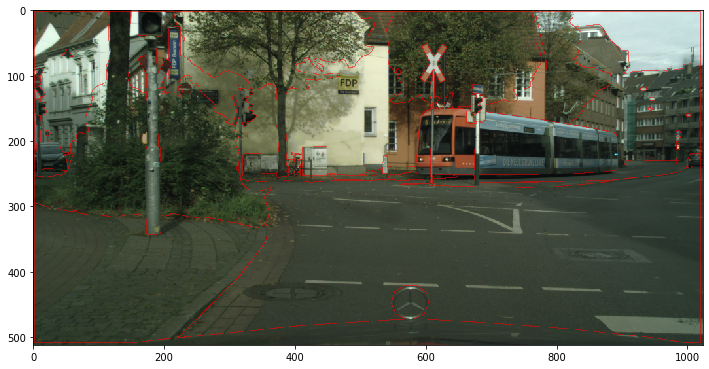

In [3]:
# Image #303 from Cityscapes works well
INDEX = 303

# We want labels. We don't need mask, transformation matrices and paired transformations.
dataset = ds.dataset(labels=True, mask=False, xf=False, pair=False)

# Get the sample
sample = dataset[INDEX]

# Extract input image and target labels
x = img_as_float(sample['image_arr'])
y = sample['labels_arr']

# We want to display the image with edges marking class boundaries
edges = roberts(y) != 0
edges = np.stack([edges, np.zeros_like(edges), np.zeros_like(edges), edges*0.75], axis=2)
edges = (edges * 255).astype(np.uint8)

plt.figure(figsize=(12, 8))
plt.imshow(x)
plt.imshow(edges, alpha=0.75)
plt.show()

# Neural network based semantic segmentation networks are fully convolutional

DNN based semantic segmentation models predict per-pixel class probability maps.
To see how this is done, let's examine their structure.

Modern DNNs designed for semantic segmentation operate in a convolutional fashion.
The first approach to do this was 
[Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038) by Long et al.
They took an ImageNet pre-trained VGG-16 network, removed the fully connected layers and replaced them with
convolutional classification layers (a 1x1 convolution), that output a 2D class probability image.
The resulting segmentation network operates in a convolutional fashion and can operate on images of (theoretically)
any size, unlike the classifier on which it is based.

More modern segmentation architectures -- such as the [DeepLab v2](https://arxiv.org/abs/1606.00915) model that we use for our Pascal VOC 2012 and Cityscapes experiments -- are more accurate network, but the approach of adapting an ImageNet classifier remains the same. DeepLab v2 is based on a ResNet-101 based backbone. It uses atrous convolutions to remove some of the downsampling and
to expand the receptive field of the output.

Some architectures such as [U-Net](https://arxiv.org/abs/1505.04597) and [DeepLab v3+](https://arxiv.org/abs/1802.02611)
add skip connections to fuse in features from earlier, higher resolution parts of the network.
None the less, semantic segmentation networks effectively operate as a stack of convolutions. As a consequence, each class probability prediction arises from a large input patch, whose size is the receptive field of the network. Thus, the network operates as a sliding window patch classifier that predicts the class of the central pixel (modulo some downsampling and upsampling operations).

It is for this reason that we examine the distribution of these input patches.

### The cluster assumption

A variant of the cluster assumption known as the low-density separation (LDS) assumption requires that the data distribution
contains clusters of samples of a uniform class, separated by regions of low sample density in between them.
It is reasonable to assume that neighbouring samples belonging to the same class will be closer to one another than
neighbouring samples belonging to different classes, as those either side of a class boundary will be on either side of
a low density region, and will most likely be further apart in Euclidean space.

Consider the image above where red lines highlight the class boundaries.
For the LDS assumption to hold we would expect to see low density regions lying along the class boundaries.
These low density regions would manifest themselves as larger distances between patches centred on neighbouring pixels
that lie on either side of a class boundary, in comparison to distances between patches centred on neighbouring pixels
that belong to the same class.

Let us consider two horizontally neighbouring patches whose central pixels (`[385,181]` and `[386,181]`) belong to different classes; `vegetation` and `building`. They are extracted from the trunk of the tree just left of the cntre of the image. We will use patches of size $31\times31$ as we can illustrate our approach easily:

Pixel A at [385, 181] belongs to class vegetation
Pixel B at [386, 181] belongs to class building


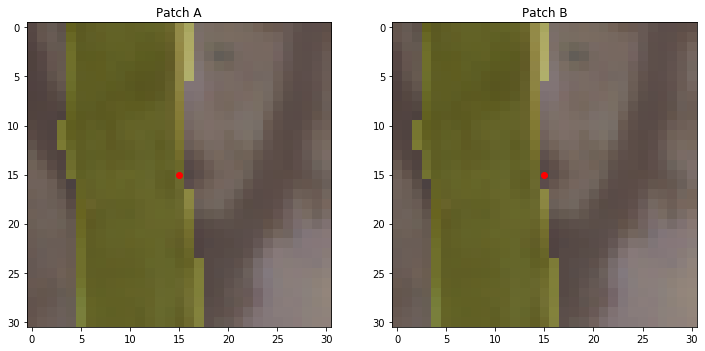

In [4]:
# Co-ordinates of neighbouring pixels that lie either side of a class boundary
p_a = [181,385]
p_b = [181,386]

print('Pixel A at {} belongs to class {}'.format(p_a[::-1], ds.class_names[y[p_a[0], p_a[1]]]))
print('Pixel B at {} belongs to class {}'.format(p_b[::-1], ds.class_names[y[p_b[0], p_b[1]]]))

# Extract 31x31 patches centred on these pixels
x_patch_a = patch_dist.extract_patch(x, (31, 31), p_a)
y_patch_a = patch_dist.extract_patch(y, (31, 31), p_a)

x_patch_b = patch_dist.extract_patch(x, (31, 31), p_b)
y_patch_b = patch_dist.extract_patch(y, (31, 31), p_b)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Patch A')
plt.imshow(x_patch_a)
plt.imshow(y_patch_a, alpha=0.25)
plt.scatter(15, 15, color='red')

plt.subplot(1, 2, 2)
plt.title('Patch B')
plt.imshow(x_patch_b)
plt.imshow(y_patch_b, alpha=0.25)
plt.scatter(15, 15, color='red')

plt.show()

The yellow overlay illustrates the change in ground truth class. The red spot indicates the central pixel.

We can compute the $L^2$ distance $d$:

In [5]:
d = np.sqrt(((x_patch_b - x_patch_a)**2).sum())
print('L2 Distance A to B = {}'.format(d))

L2 Distance A to B = 2.771186952225166


When we consider that the first step in computing $d$ requires $B-A$, we observe that this is a patch from the horizontal gradient image $\Delta_\mathrm{x}x$.
We can then verify that computing the distance $d$ between $A$ and $B$ is the same as computing the sum of the element-wise square of the patch extracted from $\Delta_\mathrm{x}x$.

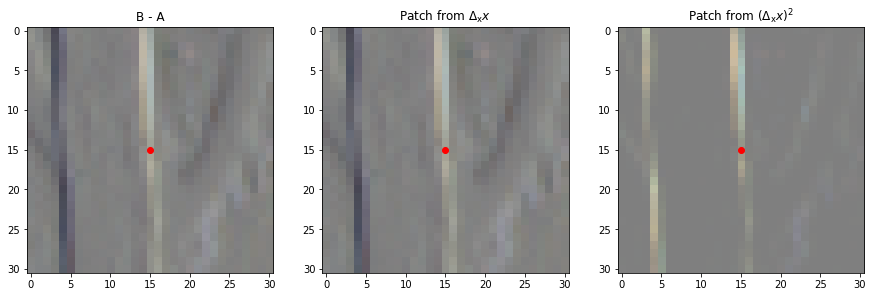

Check that B-A and the gradient patch are the same: True
Check that |B-A| and |patch_from(dIdx)| are the same: True


In [6]:
x_patch_ab = x_patch_b - x_patch_a

# Horizontal gradient image
dIdx = x[:, 1:, :] - x[:, :-1, :]
# Element-wise square of horizontal gradient image
dIdx_sqr = dIdx**2

# Extract patches
dIdx_patch = patch_dist.extract_patch(dIdx, (31, 31), p_a)
dIdx_sqr_patch = patch_dist.extract_patch(dIdx_sqr, (31, 31), p_a)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title('B - A')
plt.imshow(x_patch_ab+0.5)
plt.scatter(15, 15, color='red')

plt.subplot(1, 3, 2)
plt.title('Patch from $\Delta_\mathrm{x}x$')
plt.imshow(dIdx_patch+0.5)
plt.scatter(15, 15, color='red')

plt.subplot(1, 3, 3)
plt.title('Patch from $(\Delta_\mathrm{x}x)^2$')
# We multiply the squared grad image by 5 so that we can see something
plt.imshow(dIdx_sqr_patch*5 + 0.5)
plt.scatter(15, 15, color='red')

plt.show()

print('Check that B-A and the gradient patch are the same: {}'.format(np.allclose(x_patch_ab, dIdx_patch)))

d_from_grad = np.sqrt(dIdx_sqr_patch.sum())

print('Check that |B-A| and |patch_from(dIdx)| are the same: {}'.format(np.allclose(d, d_from_grad)))

## Computing the $L^2$ distances between neighbouring patches efficiently

We can compute the distances between neighbouring patches using a brute force approach in a reasonable amount of time if we implement it in CUDA, but there is a better way.

Computing the sum of rectangular patches extracted from an image in sliding window fashion can be performed efficiently using the cumulative sum operation. If we have a 2D array `X`, we can compute the sum of all patches of size `(h, w)` like so:

```
cs = np.cumsum(np.cumsum(X, axis=0), axis=1)
patch_sums = cs[h:,w:] - cs[:-h,w:] - cs[h:,:-w] + cs[:-h,:-w]
```

This is implemented for us by `scipy.ndimage.filters.uniform_filter`, with the caveat that it divides the result by `h * w`,
do we must multiply by `h * w` to compensate:

```
patch_sums = uniform_filter(X, (h, w), mode='constant') * h * w
```

As a consequence, we can compute the squared $L^2$ distances between neighbouring patches by applying a box filter to the element-wise square of the gradient image ($\sqrt{1^{h \times w} * (\Delta_\mathrm{x}X)^2}$):

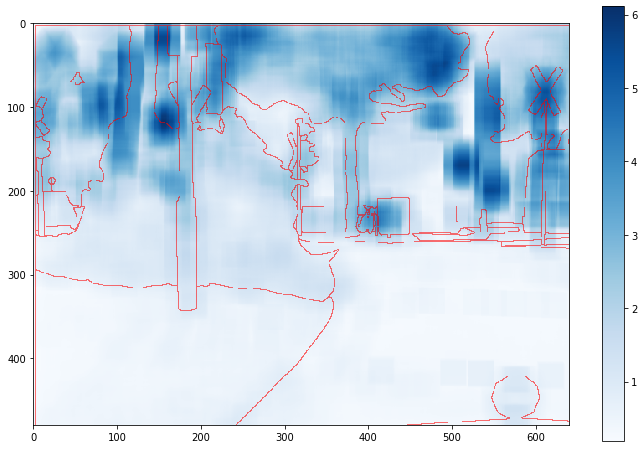

In [7]:
horizontal_distances_sqr = uniform_filter(dIdx_sqr, (31, 31, 0), mode='constant').sum(axis=2) * 31 * 31
horizontal_distances = np.sqrt(np.maximum(horizontal_distances_sqr, 0.0))

plt.figure(figsize=(12, 8))
plt.imshow(horizontal_distances[0:480, 0:640], cmap='Blues')
plt.colorbar()
plt.imshow(edges[0:480, 0:640], alpha=0.75)
plt.show()

### Function for computing average $L^2$ distance between neighbouring overlapping patches

So far we have only considered how to compute the distance between horizontally neighbouring patches.
We would prefer to compute the average of the distances between a patch centred on a pixel $p$ and its four immediate neighbours. Let's define a function that does this, returning an output of the same size for convenience:

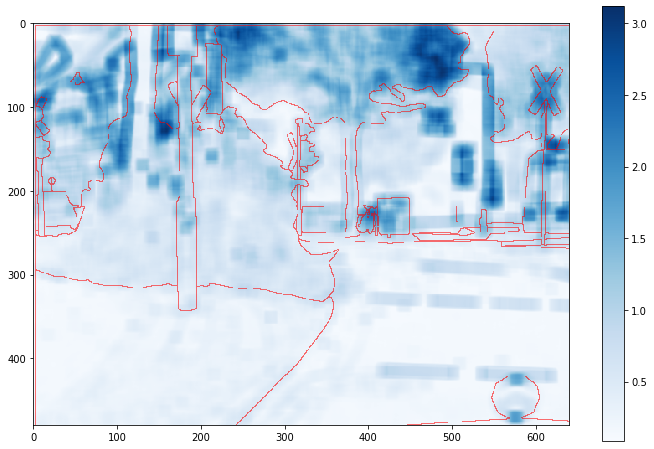

In [8]:
def average_dist_to_neighbours(x, size, d=1):
    """
    Compute average distance from each patch to the patches centred on immediately neighbouring pixels
    e.g. patch 1 pixel up, left, right, down
    
    x: image to compute patch-wise distances of
    size: size of patch
    d: size of delta used to compute gradient
    """
    d_west = x - np.pad(x, [[0, 0], [d, 0], [0, 0]], mode='reflect')[:, :-d, :]
    d_east = x - np.pad(x, [[0, 0], [0, d], [0, 0]], mode='reflect')[:, d:, :]

    d_north = x - np.pad(x, [[d, 0], [0, 0], [0, 0]], mode='reflect')[:-d, :, :]
    d_south = x - np.pad(x, [[0, d], [0, 0], [0, 0]], mode='reflect')[d:, :, :]
    
    west = uniform_filter(d_west**2, (size, size, 0), mode='constant').sum(axis=2) * size * size
    east = uniform_filter(d_east**2, (size, size, 0), mode='constant').sum(axis=2) * size * size
    north = uniform_filter(d_north**2, (size, size, 0), mode='constant').sum(axis=2) * size * size
    south = uniform_filter(d_south**2, (size, size, 0), mode='constant').sum(axis=2) * size * size
    
    west = np.maximum(west, 0.0)
    east = np.maximum(east, 0.0)
    north = np.maximum(north, 0.0)
    south = np.maximum(south, 0.0)
    
    l2_dist = (np.sqrt(west) + np.sqrt(east) + np.sqrt(north) + np.sqrt(south)) / 4.0
    return l2_dist


# Compute distance map using 15 x 15 patches
dist_map_15 = average_dist_to_neighbours(x, 15)

plt.figure(figsize=(12, 8))
plt.imshow(dist_map_15[0:480, 0:640], cmap='Blues')
plt.colorbar()
plt.imshow(edges[0:480, 0:640], alpha=0.75)
plt.show()

The above distance map is computed using $15\times15$ patches. That is a very small receptive field and is likely insufficient for a model to reliably determine the class of the central pixel. Let's try a more reasonable receptive field fo $225\times225$ pixels:

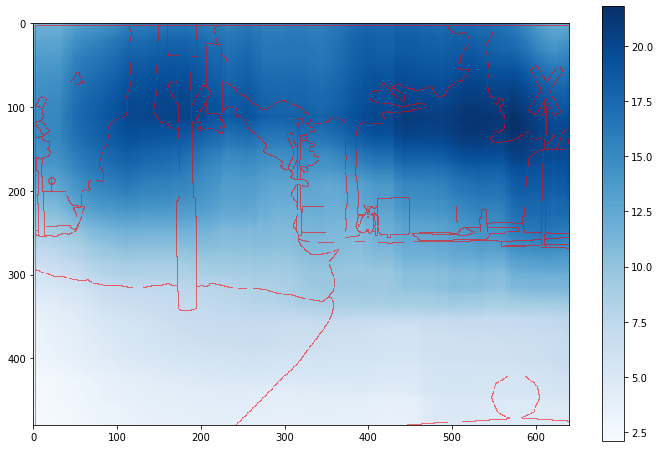

In [9]:
dist_map_225 = average_dist_to_neighbours(x, 225)

plt.figure(figsize=(12, 8))
plt.imshow(dist_map_225[0:480, 0:640], cmap='Blues')
plt.colorbar()
plt.imshow(edges[0:480, 0:640], alpha=0.75)
plt.show()

We notice that all definition is gone and that the distances to neighbouring patches vary smoothly across the image.
We also notice that there are no low density regions -- that would show as dark blue regions -- aligned with the (red) class boundaries seen above.

### Signal processing: uniform filter is a low-pass filter

The smoothness of the distance map can be easily explained from a signal processing perspective.
A uniform filter is a low-pass filter that suppresses the high frequency components of its input.
As a consequence the fine details present in the squared gradient image are suppressed, resulting in the smooth output
seen above.
This also largely negates the possibility of low density regions neatly aligning with class boundaries.
Low density regions therefore will not work as an effective signal for unsupervised learning.

## Generate the plots in the paper

In [10]:
# Change this to the directory where you would like to save the images to
OUT_DIR = None

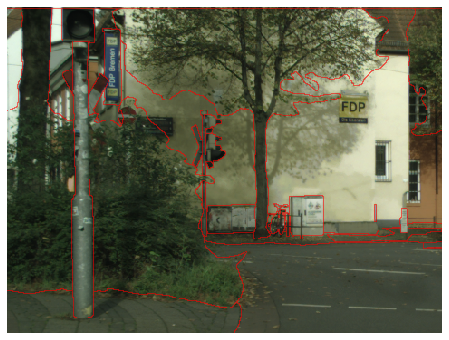

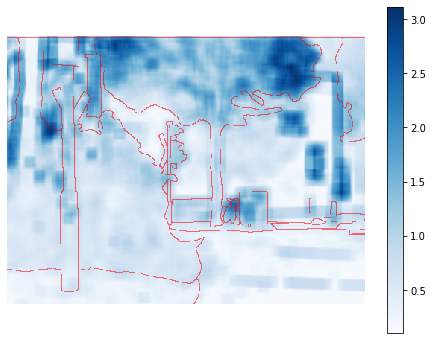

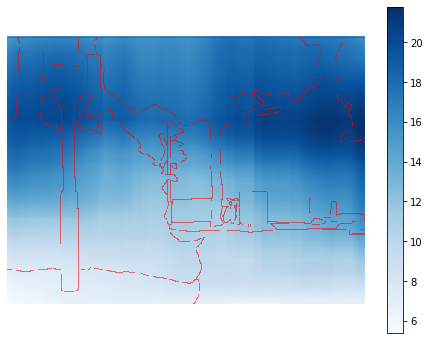

In [11]:
dist_map_15 = average_dist_to_neighbours(x, 15)
dist_map_225 = average_dist_to_neighbours(x, 225)

cm_blues = mpl.cm.get_cmap('Blues')

crop_x = x[0:360, 100:580]
crop_dist_map_15 = dist_map_15[0:360, 100:580]
crop_dist_map_225 = dist_map_225[0:360, 100:580]
crop_edges = edges[0:360, 100:580]

x_img = Image.fromarray((crop_x*255).astype(np.uint8)).convert('RGBA')
dist_map_15_img = Image.fromarray(img_as_ubyte(cm_blues(crop_dist_map_15/crop_dist_map_15.max()))).convert('RGBA')
dist_map_225_img = Image.fromarray(img_as_ubyte(cm_blues(crop_dist_map_225/crop_dist_map_225.max()))).convert('RGBA')
edges_img = Image.fromarray(crop_edges)

img1 = Image.alpha_composite(x_img, edges_img)
if OUT_DIR is not None:
    img1.save(os.path.join(OUT_DIR, 'cityscapes_l2_image.png'))

img2 = Image.alpha_composite(dist_map_15_img, edges_img)
if OUT_DIR is not None:
    img2.save(os.path.join(OUT_DIR, 'cityscapes_l2_patch_dist_15.png'))

img3 = Image.alpha_composite(dist_map_225_img, edges_img)
if OUT_DIR is not None:
    img3.save(os.path.join(OUT_DIR, 'cityscapes_l2_patch_dist_225.png'))


plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.axis('off')
plt.imshow(crop_x)
plt.imshow(crop_edges, alpha=0.75)
# plt.savefig(os.path.join(OUT_DIR, 'cityscapes_l2_image.pdf'), dpi=300)
plt.show()

plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.axis('off')
plt.imshow(crop_dist_map_15, cmap='Blues')
plt.colorbar()
plt.imshow(crop_edges, alpha=0.75)
# plt.savefig(os.path.join(OUT_DIR, 'cityscapes_l2_patch_dist_15.pdf'), dpi=300)
plt.show()

plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.axis('off')
plt.imshow(crop_dist_map_225, cmap='Blues')
plt.colorbar()
plt.imshow(crop_edges, alpha=0.75)
# plt.savefig(os.path.join(OUT_DIR, 'cityscapes_l2_patch_dist_225.pdf'), dpi=300)
plt.show()
